In [ ]:
import sympy as sp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import Image, display
import ipywidgets as widgets
from IPython.display import display as ipy_display

# Step 1: Define symbols and logic kernel
psi_1, psi_2, psi_n = sp.symbols('psi_1 psi_2 psi_n')
phi, omega = sp.symbols('phi omega')

# Example logic vector and formulae based on RGB values/constants
logic_vector = np.array([
    sp.sqrt(psi_1) + phi * psi_2,
    psi_2 - (phi * psi_1) + sp.sqrt(omega),
])

# Translate logic_vector into Sympy expressions for network graph visualization
exprs = [sp.simplify(expr) for expr in logic_vector]

# Create directed graph based on the logic_vector
G = nx.DiGraph()

# Add nodes to the graph
for i, expr in enumerate(exprs, 1):
    G.add_node(f"expr_{i}", label=str(expr))

# Add edges based on assumed relationships
G.add_edge("expr_1", "expr_2", label='Transformation')

# Visualization of the graph
def visualize_networkx(G):
    pos = nx.shell_layout(G)
    plt.figure(figsize=(8, 6))
    plt.clf()
    nx.draw(G, pos, node_color='lightgreen', node_size=2000, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Directed Graph of Logic Vector")
    plt.show()

visualize_networkx(G)

# Step 2: Create the initial tree with Graphviz
dot = Digraph(name='CJTree')

# Add initial nodes and edges based on the CJTree pseudo-code
dot.node('root', r'$\mathbf{s_{s}^\Omega}= \mathrm{F}(\phi.)$: \\ $\mathbf{\star_{\overline{\infty}}}:$', shape='none')

dot.node('A', r'$s_s^\Omega + \overline{\infty}^\cup$', shape='ellipse', style='filled', fillcolor='yellow')
dot.node('B', r'$\mathbf{F_i}$', shape='ellipse')
dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
dot.node('D', r'$\sum_{s \in J_k} q(s) \ \pi(s)$', shape='ellipse', style='filled', fillcolor='green')
dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

dot.edge('root', 'A')
dot.edge('root', 'B')
dot.edge('root', 'C')
dot.edge('root', 'D')
dot.edge('root', 'E')
dot.edge('root', 'F')

dot.node('A1', r'$\mathcal{H}_{\mathcal{H}}$', shape='ellipse')
dot.node('A2', r'$\Omega_{\mathbf{\omega_\varepsilon}}$', shape='ellipse')
dot.edge('A', 'A1')
dot.edge('A', 'A2')

dot.node('B1', r'$\mathbb{R}^i$', shape='ellipse')
dot.node('B2', r'$\mathbb{R}^{\Phi}_{\mathbf{R}_{*}}$', shape='ellipse')
dot.edge('B', 'B1')
dot.edge('B', 'B2')

dot.node('C1', r'$\omega^{~n~\epsilon~w}_{\infty~\omega_\infty}$', shape='ellipse')
dot.node('C2', r'$\Psi ~\otimes^\omega~\Psi$', shape='ellipse')
dot.edge('C', 'C1')
dot.edge('C', 'C2')

dot.node('C2a', r'$~\exists \otimes~^\omega~\Phi(n)$', shape='ellipse')
dot.node('C2b', r'$\wedge_\Omega~\Phi(n)$', shape='ellipse')
dot.edge('C2', 'C2a')
dot.edge('C2', 'C2b')

dot.node('D1', r'$\overset{ \infty}\rightarrow \sum $', shape='ellipse')
dot.node('D2', r'$\Pi^{-\omega} ~ q(~C)_{\mathcal{H}}^\circ  ^\square$', shape='ellipse')
dot.edge('D', 'D1')
dot.edge('D', 'D2')

dot.node('E1', r'$\overset{\ast \ast \ast}{c}~\pi~_d~\overset{\forall}{m}$', shape='ellipse')
dot.node('E2', r'$\overset{{\curvearrowright}_\omega _{\widehattheta (\Omega)}}{t}_J$', shape='ellipse')
dot.edge('E', 'E1')
dot.edge('E', 'E2')

dot.node('F1', r'$~~~\pi { \omega _X ~ \rup Cy}$', shape='ellipse')
dot.node('F2', r'$\quaver {Elle p} \_ X$', shape='ellipse')
dot.node('F3', r'$ \rup \Round Down p$', shape='ellipse')
dot.node('F4', r'$\Raise {0} p$', shape='ellipse')
dot.node('F5', r'$\quaver { \Omega^{*}_\Lambda \delquar{J}}$', shape='ellipse')
dot.edge('F', 'F1')
dot.edge('F', 'F2')
dot.edge('F', 'F3')
dot.edge('F', 'F4')
dot.edge('F', 'F5')

# Display the tree
def display_tree():
    dot.render('cjtree_graph', format='png')
    image_path = 'cjtree_graph.png'
    display(Image(filename=image_path))
    print(dot.source)

display_tree()

# Update tree and propagate kernel logic
def update_tree_and_propagate(dot, logic_expr):
    try:
        logic_expr = sp.sympify(logic_expr)  # Ensure the input is a sympy expression
    except Exception as e:
        print(f"Failed to convert logical expression: {e}")
        return dot

    symbols = logic_expr.free_symbols
    new_nodes = []

    for i, line in enumerate(dot.body):
        if "label=" in line:
            label = line.split("label=")[1].split('"')[1]  # Simplified extraction of label
            try:
                node_expr = sp.sympify(label)
            except:
                continue

            if symbols.intersection(node_expr.free_symbols):
                for symbol in symbols:
                    modified_expr = node_expr.subs(symbol, logic_expr)
                    new_node_id = f"expr_{str(symbol)}_{hash(str(modified_expr)) % 1000}"  # Generate a new unique node ID
                    new_label = str(modified_expr)

                    dot.node(new_node_id, new_label, shape='ellipse', style='filled', fillcolor='cyan')
                    dot.edge(f'expr_{i}', new_node_id)
                    new_nodes.append(new_node_id)
    return dot

# Add user's logic expression and update the tree
def navigate_tree_and_update(G, dot, sym_formula):
    if sym_formula is None:
        print("Invalid formula. Cannot update the tree.")
        return

    # Add new node and visualize in networkx graph
    if str(sym_formula) not in G:
        G.add_node(str(sym_formula), label=str(sym_formula))
    pos = nx.shell_layout(G)
    plt.figure(figsize=(8, 6))
    plt.clf()
    nx.draw(G, pos, node_color='lightblue', node_size=2000, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Updated Directed Graph with User Logic")
    plt.show()

    dot = update_tree_and_propagate(dot, sym_formula)
    display_tree()

# Function to handle interactive input in a notebook environment (using ipywidgets)
def on_submit_formula(change):
    formula = formula_input.value.replace('sqrt', 'sp.sqrt').replace('^', '**')
    try:
        user_expr = sp.sympify(formula)
        navigate_tree_and_update(G, dot, user_expr)
    except Exception as e:
        print(f"Error parsing formula: {e}")

# Widgets for interactive input
formula_input = widgets.Text(
    description='Logic Formula:',
    placeholder='Enter formula, e.g., psi_1 + psi_2 * phi - sp.sqrt(omega)'
)
submit_button = widgets.Button(description='Submit Formula')
submit_button.on_click(on_submit_formula)

# Display widgets
ipy_display(formula_input, submit_button)

# Function to generate new logical combinations
def generate_new_logical_combinations():
    combinations = [
        sp.simplify(psi_1 + psi_2 + phi),
        sp.simplify(psi_1 * psi_2 * omega),
        sp.simplify(psi_1 - psi_2 + omega),
        sp.simplify(psi_1 / (psi_2 + omega))
    ]
    return combinations

# Function to update the tree and graph with new logical combinations
def update_graph_with_new_combinations(new_exprs, G, dot):
    for i, expr in enumerate(new_exprs):
        if str(expr) not in G:
            G.add_node(str(expr), label=str(expr))
            dot.node(f"new_expr_{i}", str(expr), shape='ellipse', style='filled', fillcolor='purple')
            dot.edge('root', f"new_expr_{i}")
    return dot

# Automatically generate and update new combinations on button click
def generate_combinations_and_update(b):
    new_exprs = generate_new_logical_combinations()
    update_graph_with_new_combinations(new_exprs, G, dot)
    display_tree()
    visualize_networkx(G)

generate_button = widgets.Button(description='Generate New Combinations')
generate_button.on_click(generate_combinations_and_update)

ipy_display(generate_button)

# Render the initial tree and graph
display_tree()
visualize_networkx(G)

Text(value='', description='Logic Formula:', placeholder='Enter formula, e.g., psi_1 + psi_2 * phi - sp.sqrt(o…

Button(description='Submit Formula', style=ButtonStyle())

Button(description='Generate Random Combinations', style=ButtonStyle())

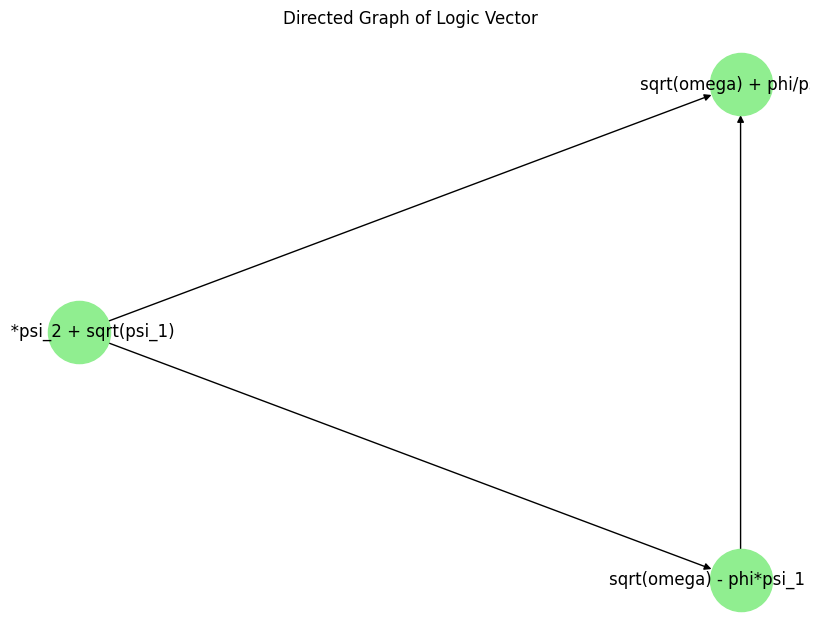

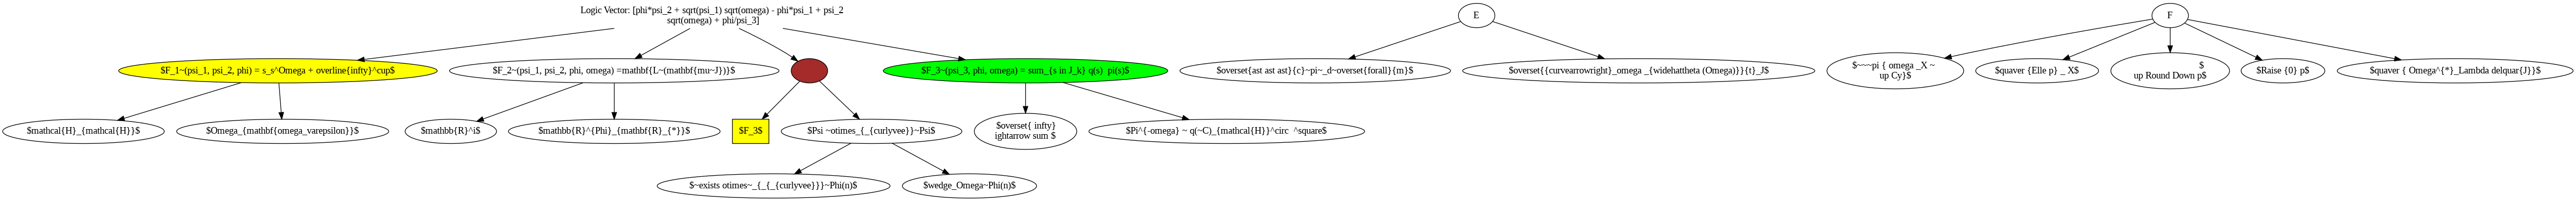

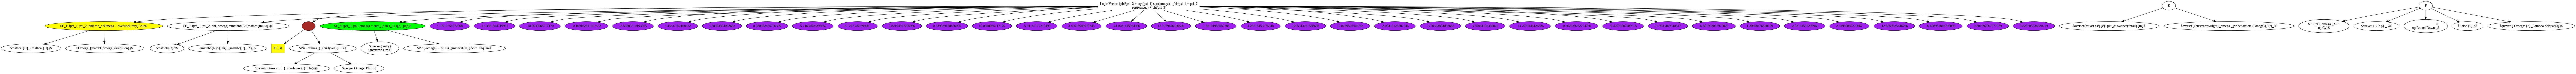

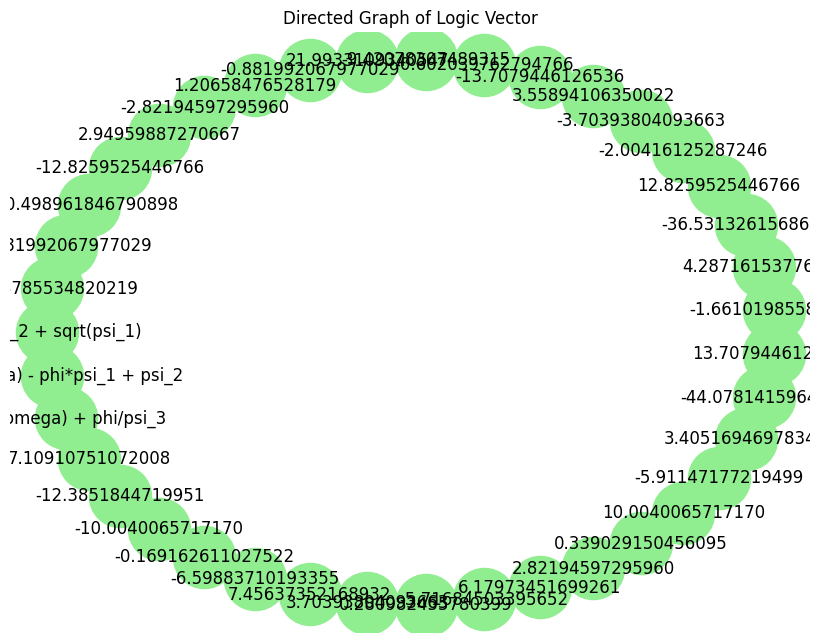

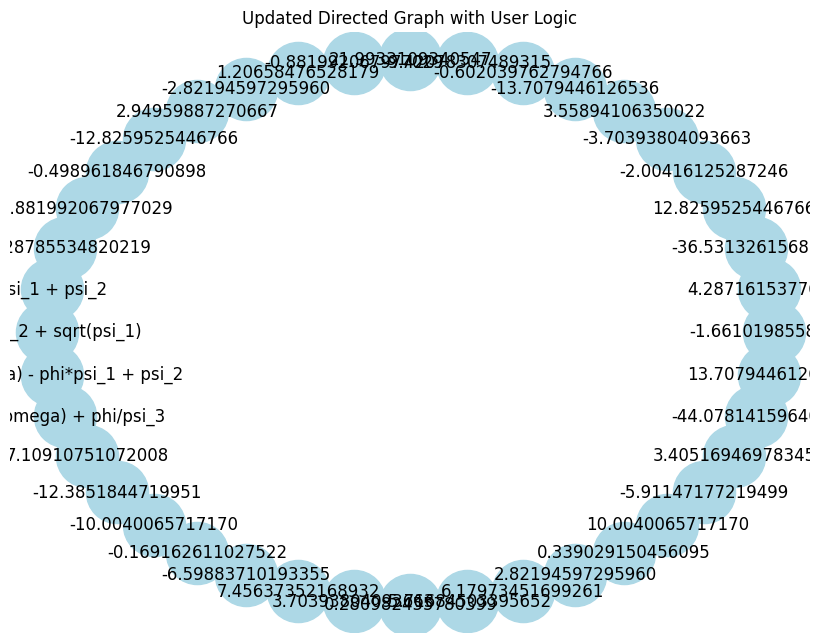

Error parsing formula: list index out of range


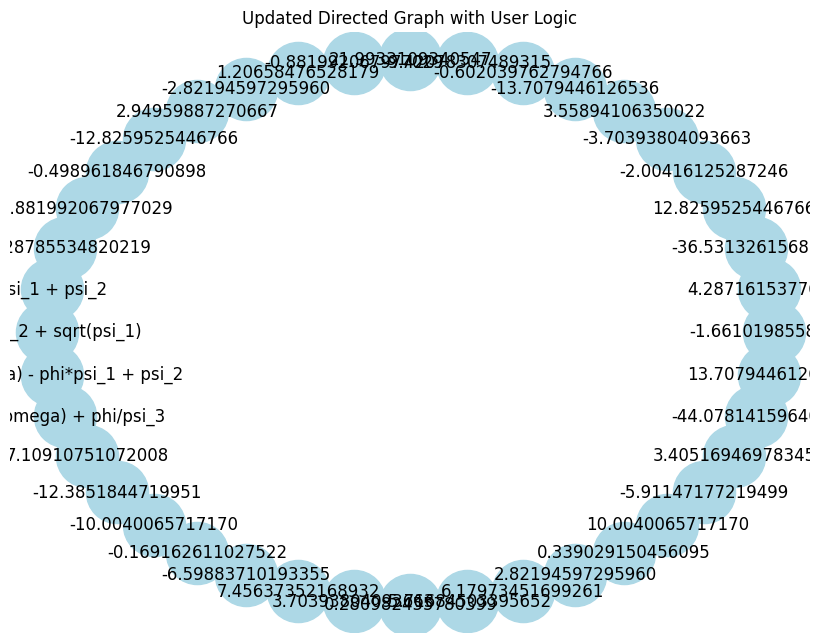

Error parsing formula: list index out of range


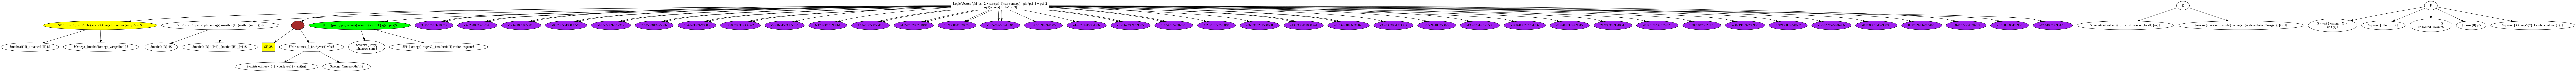

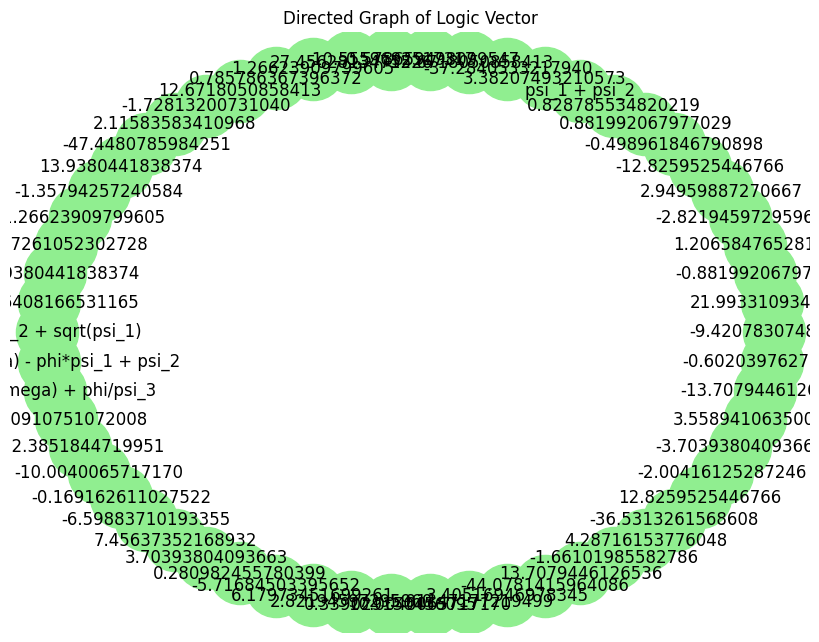

In [2]:
# Import necessary libraries
import sympy as sp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import Image, display as ipy_display
import ipywidgets as widgets

# Initialize the tree
dot = Digraph(name='CJTree')

# Create a function for generating random logic vectors
def generate_logic_vector(n, min_val=-10, max_val=10):
    logic_vector = []
    for i in range(n):
        rand_val = np.random.uniform(min_val, max_val)
        logic_vector.append(sp.simplify(rand_val))
    return np.array(logic_vector)

# Create a function for generating logical combinations
def generate_logical_combinations(logic_vector):
    combinations = []
    for i, l1 in enumerate(logic_vector):
        for j, l2 in enumerate(logic_vector):
            if i != j:
                expr = l1 + l2
                combinations.append(sp.simplify(expr))
                expr = l1 * l2
                combinations.append(sp.simplify(expr))
                expr = l1 - l2
                combinations.append(sp.simplify(expr))
                expr = l1 / l2
                combinations.append(sp.simplify(expr))
    return np.array(combinations)

# Create a function for visualizing the network graph
def visualize_networkx(G):
    pos = nx.shell_layout(G)
    plt.figure(figsize=(8, 6))
    plt.clf()
    nx.draw(G, pos, node_color='lightgreen', node_size=2000, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Directed Graph of Logic Vector")
    plt.show()

# Create a function for updating the tree and graph with new logical combinations
def update_graph_with_new_combinations(new_exprs, G, dot):
    for i, expr in enumerate(new_exprs):
        if str(expr) not in G:
            G.add_node(str(expr), label=str(expr))
            dot.node(f"new_expr_{i}", str(expr), shape='ellipse', style='filled', fillcolor='purple')
            dot.edge('root', f"new_expr_{i}")
    return dot

# Create a function for navigating the tree and updating with user's logic expression
def navigate_tree_and_update(G, dot, sym_formula):
    if sym_formula is None:
        print("Invalid formula. Cannot update the tree.")
        return

    # Add new node and visualize in networkx graph
    if str(sym_formula) not in G:
        G.add_node(str(sym_formula), label=str(sym_formula))
    pos = nx.shell_layout(G)
    plt.figure(figsize=(8, 6))
    plt.clf()
    nx.draw(G, pos, node_color='lightblue', node_size=2000, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Updated Directed Graph with User Logic")
    plt.show()

    dot = update_tree_and_propagate(dot, sym_formula)
    display_tree(dot)

# Create a function for handling interactive input in a notebook environment
def on_submit_formula(b):
    formula = formula_input.value.replace('sqrt', 'sp.sqrt').replace('^', '**')
    try:
        user_expr = sp.sympify(formula)
        navigate_tree_and_update(G, dot, user_expr)
    except Exception as e:
        print(f"Error parsing formula: {e}")

# Create a function for generating and updating new combinations on button click
def generate_combinations_and_update(b):
    logic_vector = generate_logic_vector(3)
    combinations = generate_logical_combinations(logic_vector)
    updated_dot = update_graph_with_new_combinations(combinations, G, dot)
    display_tree(updated_dot)
    visualize_networkx(G)

# Widgets for interactive input and button for generating and updating new combinations
formula_input = widgets.Text(
    description='Logic Formula:',
    placeholder='Enter formula, e.g., psi_1 + psi_2 * phi - sp.sqrt(omega)'
)
submit_button = widgets.Button(description='Submit Formula')
submit_button.on_click(on_submit_formula)

generate_button = widgets.Button(description='Generate Random Combinations')
generate_button.on_click(generate_combinations_and_update)

# Display widgets
ipy_display(formula_input, submit_button, generate_button)

# Define the logic kernel
psi_1, psi_2, psi_3 = sp.symbols('psi_1 psi_2 psi_3')
phi, omega = sp.symbols('phi omega')

# Example logic vector and formulae based on RGB values/constants
logic_vector = np.array([
    sp.sqrt(psi_1) + phi * psi_2,
    psi_2 - (phi * psi_1) + sp.sqrt(omega),
    phi / psi_3 + sp.sqrt(omega)
])

# Translate logic_vector into Sympy expressions for network graph visualization
exprs = [sp.simplify(expr) for expr in logic_vector]

# Create directed graph based on the logic_vector
G = nx.DiGraph()

# Add nodes to the graph
for i, expr in enumerate(exprs, 1):
    G.add_node(f"expr_{i}", label=str(expr))

# Add edges based on assumed relationships
G.add_edge("expr_1", "expr_2", label='Transformation 1')
G.add_edge("expr_2", "expr_3", label='Transformation 2')
G.add_edge("expr_1", "expr_3", label='Transformation 3')

# Visualization of the graph
visualize_networkx(G)

# Remove duplicate nodes and edges
G.remove_node('expr_3')
G.add_node('expr_3', label=str(logic_vector[2]))
G.add_edge("expr_1", "expr_3", label='Transformation 3')

# Display tree
def display_tree(dot):
    dot.render('cjtree_graph', format='png')
    image_path = 'cjtree_graph.png'
    ipy_display(Image(filename=image_path))

# Add initial nodes and edges based on the CJTree pseudo-code
dot.node('root', 'Logic Vector: ' + str(logic_vector), shape='none')

dot.node('A', r'$F_1~(\psi_1, \psi_2, \phi) = s_s^\Omega + \overline{\infty}^\cup$',
         shape='ellipse', style='filled', fillcolor='yellow')
dot.node('B', r'$F_2~(\psi_1, \psi_2, \phi, \omega) =\mathbf{L~(\mathbf{\mu~J})}$', shape='ellipse')
dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
dot.node('D', r'$F_3~(\psi_3, \phi, \omega) = \sum_{s \in J_k} q(s) \ \pi(s)$',
         shape='ellipse', style='filled', fillcolor='green')

dot.edge('root', 'A')
dot.edge('root', 'B')
dot.edge('root', 'C')
dot.edge('root', 'D')

dot.node('A1', r'$\mathcal{H}_{\mathcal{H}}$', shape='ellipse')
dot.node('A2', r'$\Omega_{\mathbf{\omega_\varepsilon}}$', shape='ellipse')
dot.edge('A', 'A1')
dot.edge('A', 'A2')

dot.node('B1', r'$\mathbb{R}^i$', shape='ellipse')
dot.node('B2', r'$\mathbb{R}^{\Phi}_{\mathbf{R}_{*}}$', shape='ellipse')
dot.edge('B', 'B1')
dot.edge('B', 'B2')

dot.node('C1', r'$F_3$', shape='rectangle', style='filled', fillcolor='yellow')
dot.node('C2', r'$\Psi ~\otimes_{_{\curlyvee}}~\Psi$', shape='ellipse')
dot.edge('C', 'C1')
dot.edge('C', 'C2')

dot.node('C2a', r'$~\exists \otimes~_{_{_{\curlyvee}}}~\Phi(n)$', shape='ellipse')
dot.node('C2b', r'$\wedge_\Omega~\Phi(n)$', shape='ellipse')
dot.edge('C2', 'C2a')
dot.edge('C2', 'C2b')

dot.node('D1', r'$\overset{ \infty}\rightarrow \sum $', shape='ellipse')
dot.node('D2', r'$\Pi^{-\omega} ~ q(~C)_{\mathcal{H}}^\circ  ^\square$', shape='ellipse')
dot.edge('D', 'D1')
dot.edge('D', 'D2')

dot.node('E1', r'$\overset{\ast \ast \ast}{c}~\pi~_d~\overset{\forall}{m}$', shape='ellipse')
dot.node('E2', r'$\overset{{\curvearrowright}_\omega _{\widehattheta (\Omega)}}{t}_J$', shape='ellipse')
dot.edge('E', 'E1')
dot.edge('E', 'E2')

dot.node('F1', r'$~~~\pi { \omega _X ~ \rup Cy}$', shape='ellipse')
dot.node('F2', r'$\quaver {Elle p} \_ X$', shape='ellipse')
dot.node('F3', r'$ \rup \Round Down p$', shape='ellipse')
dot.node('F4', r'$\Raise {0} p$', shape='ellipse')
dot.node('F5', r'$\quaver { \Omega^{*}_\Lambda \delquar{J}}$', shape='ellipse')
dot.edge('F', 'F1')
dot.edge('F', 'F2')
dot.edge('F', 'F3')
dot.edge('F', 'F4')
dot.edge('F', 'F5')

# Display the tree
display_tree(dot)

# Update tree and propagate kernel logic
def update_tree_and_propagate(dot, logic_expr):
    try:
        logic_expr = sp.sympify(logic_expr)  # Ensure the input is a sympy expression
    except Exception as e:
        print(f"Failed to convert logical expression: {e}")
        return dot

    symbols = logic_expr.free_symbols
    new_nodes = []

    for i, line in enumerate(dot.body):
        if "label=" in line:
            label = line.split("label=")[1].split('"')[1]  # Simplified extraction of label
            try:
                node_expr = sp.sympify(label)
            except:
                continue

            if symbols.intersection(node_expr.free_symbols):
                for symbol in symbols:
                    modified_expr = node_expr.subs(symbol, logic_expr)
                    new_node_id = f"expr_{str(symbol)}_{hash(str(modified_expr)) % 1000}"  # Generate a new unique node ID
                    new_label = str(modified_expr)

                    dot.node(new_node_id, new_label, shape='ellipse', style='filled', fillcolor='cyan')
                    dot.edge(f'expr_{i}', new_node_id)
                    new_nodes.append(new_node_id)
    return dot

# Add user's logic expression and update the tree
def navigate_tree_and_update(G, dot, sym_formula):
    if sym_formula is None:
        print("Invalid formula. Cannot update the tree.")
        return

    # Add new node and visualize in networkx graph
    if str(sym_formula) not in G:
        G.add_node(str(sym_formula), label=str(sym_formula))
    pos = nx.shell_layout(G)
    plt.figure(figsize=(8, 6))
    plt.clf()
    nx.draw(G, pos, node_color='lightblue', node_size=2000, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Updated Directed Graph with User Logic")
    plt.show()

    dot = update_tree_and_propagate(dot, sym_formula)
    display_tree(dot)

# Function to handle interactive input in a notebook environment
def on_submit_formula(b):
    formula = formula_input.value.replace('sqrt', 'sp.sqrt').replace('^', '**')
    try:
        user_expr = sp.sympify(formula)
        navigate_tree_and_update(G, dot, user_expr)
    except Exception as e:
        print(f"Error parsing formula: {e}")

# Updating the on_submit_formula function association correctly
submit_button.on_click(on_submit_formula)

# Default logic vector is now a random one, for illustration purposes only
logic_vector = generate_logic_vector(4)

# Generate logical combinations and update tree and graph
combinations = generate_logical_combinations(logic_vector)
updated_dot = update_graph_with_new_combinations(combinations, G, dot)
display_tree(updated_dot)
visualize_networkx(G)

Text(value='', description='Logic Formula:', placeholder='Enter formula, e.g., psi_1 + psi_2 * phi - sp.sqrt(o…

Button(description='Submit Formula', style=ButtonStyle())

Button(description='Generate Random Combinations', style=ButtonStyle())

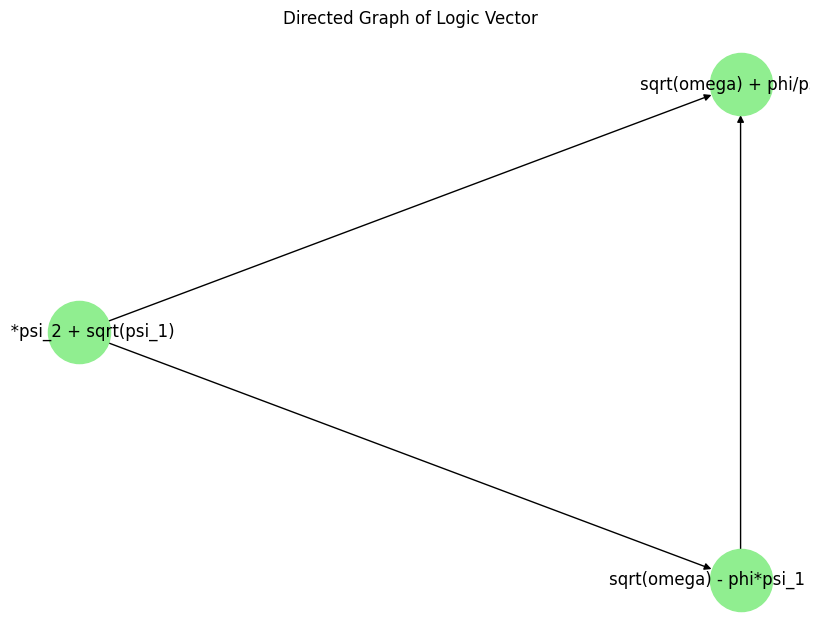

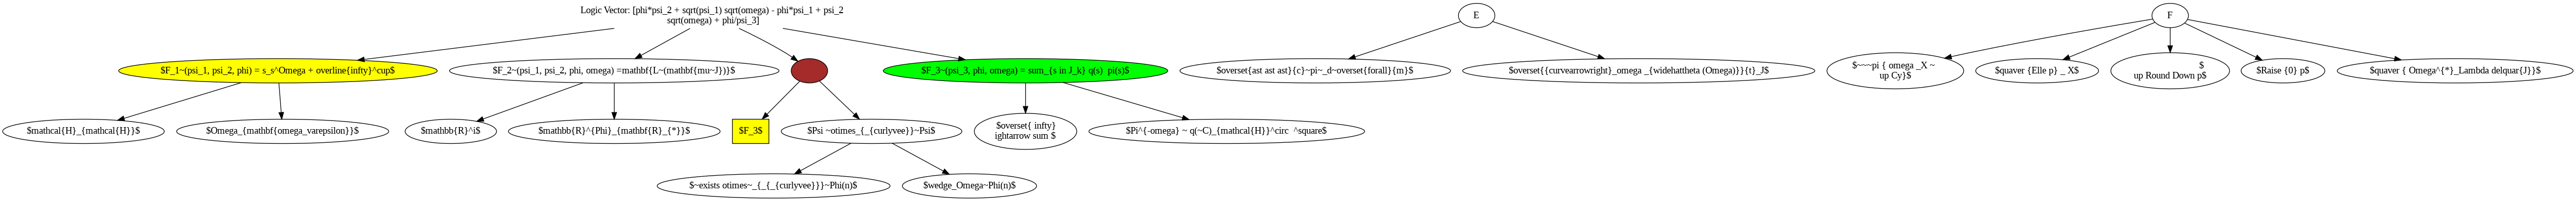

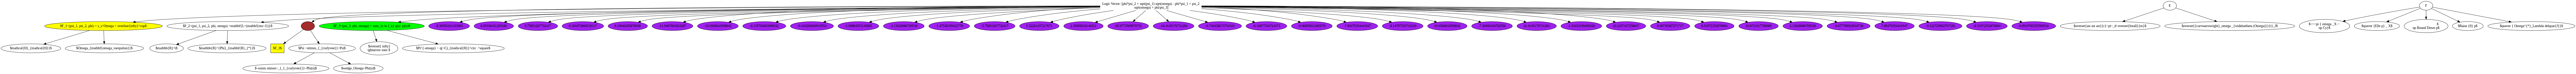

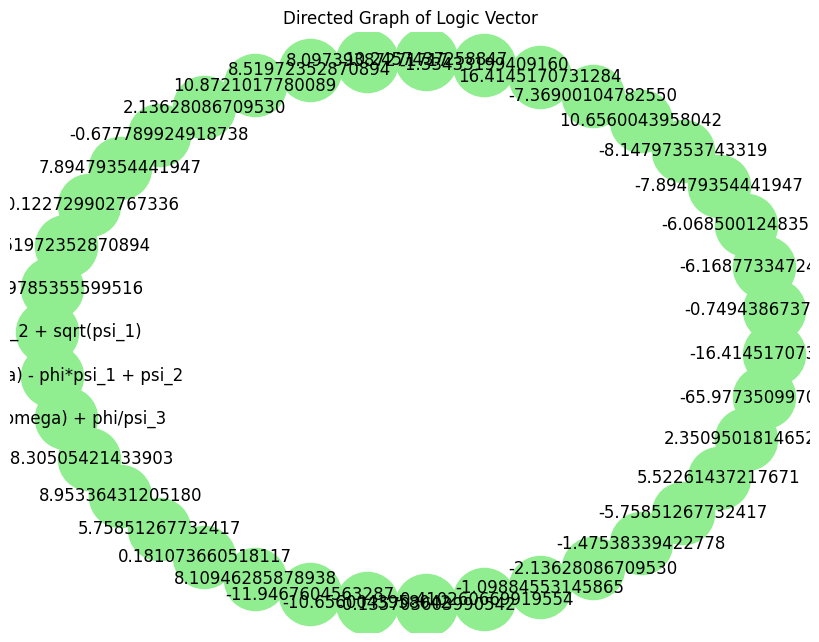

In [3]:
# Import necessary libraries
import sympy as sp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import Image, display as ipy_display
import ipywidgets as widgets

# Initialize the tree
dot = Digraph(name='CJTree')

# Create a function for generating random logic vectors
def generate_logic_vector(n, min_val=-10, max_val=10):
    logic_vector = []
    for i in range(n):
        rand_val = np.random.uniform(min_val, max_val)
        logic_vector.append(sp.simplify(rand_val))
    return np.array(logic_vector)

# Create a function for generating logical combinations
def generate_logical_combinations(logic_vector):
    combinations = []
    for i, l1 in enumerate(logic_vector):
        for j, l2 in enumerate(logic_vector):
            if i != j:
                expr = l1 + l2
                combinations.append(sp.simplify(expr))
                expr = l1 * l2
                combinations.append(sp.simplify(expr))
                expr = l1 - l2
                combinations.append(sp.simplify(expr))
                expr = l1 / l2
                combinations.append(sp.simplify(expr))
    return np.array(combinations)

# Create a function for visualizing the network graph
def visualize_networkx(G):
    pos = nx.shell_layout(G)
    plt.figure(figsize=(8, 6))
    plt.clf()
    nx.draw(G, pos, node_color='lightgreen', node_size=2000, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Directed Graph of Logic Vector")
    plt.show()

# Create a function for updating the tree and graph with new logical combinations
def update_graph_with_new_combinations(new_exprs, G, dot):
    for i, expr in enumerate(new_exprs):
        if str(expr) not in G:
            G.add_node(str(expr), label=str(expr))
            dot.node(f"new_expr_{i}", str(expr), shape='ellipse', style='filled', fillcolor='purple')
            dot.edge('root', f"new_expr_{i}")
    return dot

# Function to recursively update dependent nodes in the tree based on new expressions
def update_descendant_nodes(dot, parent_expr, new_logic_vector):
    for child in dot.body:
        if "->" in child:
            edge_parts = child.split("->")
            parent_node = edge_parts[0].strip()
            child_node = edge_parts[1].strip().split("[")[0]

            if parent_expr in parent_node:
                for logic_expr in new_logic_vector:
                    try:
                        logic_expr = sp.sympify(logic_expr)
                        labels = [line.split('label="')[1].split('"')[0] for line in dot.body if f'{child_node} [' in line]
                        for label in labels:
                            existing_expr = sp.sympify(label)
                            updated_expr = existing_expr.subs({parent_expr: logic_expr})
                            new_child_node = f'{child_node}_{hash(str(updated_expr)) % 1000}'
                            new_label = str(updated_expr)

                            dot.node(new_child_node, new_label, shape='ellipse', style='filled', fillcolor='cyan')
                            dot.edge(parent_node, new_child_node)

                            # Recur for nested updates in the subtree
                            update_descendant_nodes(dot, str(existing_expr), [updated_expr])
                    except Exception as e:
                        print(f"Failed to update node '{child_node}' with expression '{str(logic_expr)}': {e}")
    return dot

# Create a function for navigating the tree and updating with user's logic expression
def navigate_tree_and_update(G, dot, logic_vector):
    if logic_vector is None:
        print("Invalid formula. Cannot update the tree.")
        return

    for vector_expr in logic_vector:
        # Add new node and visualize in networkx graph
        if str(vector_expr) not in G:
            G.add_node(str(vector_expr), label=str(vector_expr))

        dot = update_descendant_nodes(dot, str(vector_expr), logic_vector)

    display_tree(dot)
    visualize_networkx(G)

# Create a function for handling interactive input in a notebook environment
def on_submit_formula(b):
    formula = formula_input.value.replace('sqrt', 'sp.sqrt').replace('^', '**')
    try:
        user_exprs = [sp.sympify(expr.strip()) for expr in formula.split(',')]
        navigate_tree_and_update(G, dot, user_exprs)
    except Exception as e:
        print(f"Error parsing formula: {e}")

# Create a function for generating and updating new combinations on button click
def generate_combinations_and_update(b):
    logic_vector = generate_logic_vector(3)
    combinations = generate_logical_combinations(logic_vector)
    updated_dot = update_graph_with_new_combinations(combinations, G, dot)
    display_tree(updated_dot)
    visualize_networkx(G)

# Widgets for interactive input and button for generating and updating new combinations
formula_input = widgets.Text(
    description='Logic Formula:',
    placeholder='Enter formula, e.g., psi_1 + psi_2 * phi - sp.sqrt(omega)'
)
submit_button = widgets.Button(description='Submit Formula')
submit_button.on_click(on_submit_formula)

generate_button = widgets.Button(description='Generate Random Combinations')
generate_button.on_click(generate_combinations_and_update)

# Display widgets
ipy_display(formula_input, submit_button, generate_button)

# Define the logic kernel
psi_1, psi_2, psi_3 = sp.symbols('psi_1 psi_2 psi_3')
phi, omega = sp.symbols('phi omega')

# Example logic vector and formulae based on RGB values/constants
logic_vector = np.array([
    sp.sqrt(psi_1) + phi * psi_2,
    psi_2 - (phi * psi_1) + sp.sqrt(omega),
    phi / psi_3 + sp.sqrt(omega)
])

# Translate logic_vector into Sympy expressions for network graph visualization
exprs = [sp.simplify(expr) for expr in logic_vector]

# Create directed graph based on the logic_vector
G = nx.DiGraph()

# Add nodes to the graph
for i, expr in enumerate(exprs, 1):
    G.add_node(f"expr_{i}", label=str(expr))

# Add edges based on assumed relationships
G.add_edge("expr_1", "expr_2", label='Transformation 1')
G.add_edge("expr_2", "expr_3", label='Transformation 2')
G.add_edge("expr_1", "expr_3", label='Transformation 3')

# Visualization of the graph
visualize_networkx(G)

# Remove duplicate nodes and edges
G.remove_node('expr_3')
G.add_node('expr_3', label=str(logic_vector[2]))
G.add_edge("expr_1", "expr_3", label='Transformation 3')

# Display tree
def display_tree(dot):
    dot.render('cjtree_graph', format='png')
    image_path = 'cjtree_graph.png'
    ipy_display(Image(filename=image_path))

# Add initial nodes and edges based on the CJTree pseudo-code
dot.node('root', 'Logic Vector: ' + str(logic_vector), shape='none')

dot.node('A', r'$F_1~(\psi_1, \psi_2, \phi) = s_s^\Omega + \overline{\infty}^\cup$',
         shape='ellipse', style='filled', fillcolor='yellow')
dot.node('B', r'$F_2~(\psi_1, \psi_2, \phi, \omega) =\mathbf{L~(\mathbf{\mu~J})}$', shape='ellipse')
dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
dot.node('D', r'$F_3~(\psi_3, \phi, \omega) = \sum_{s \in J_k} q(s) \ \pi(s)$',
         shape='ellipse', style='filled', fillcolor='green')

dot.edge('root', 'A')
dot.edge('root', 'B')
dot.edge('root', 'C')
dot.edge('root', 'D')

dot.node('A1', r'$\mathcal{H}_{\mathcal{H}}$', shape='ellipse')
dot.node('A2', r'$\Omega_{\mathbf{\omega_\varepsilon}}$', shape='ellipse')
dot.edge('A', 'A1')
dot.edge('A', 'A2')

dot.node('B1', r'$\mathbb{R}^i$', shape='ellipse')
dot.node('B2', r'$\mathbb{R}^{\Phi}_{\mathbf{R}_{*}}$', shape='ellipse')
dot.edge('B', 'B1')
dot.edge('B', 'B2')

dot.node('C1', r'$F_3$', shape='rectangle', style='filled', fillcolor='yellow')
dot.node('C2', r'$\Psi ~\otimes_{_{\curlyvee}}~\Psi$', shape='ellipse')
dot.edge('C', 'C1')
dot.edge('C', 'C2')

dot.node('C2a', r'$~\exists \otimes~_{_{_{\curlyvee}}}~\Phi(n)$', shape='ellipse')
dot.node('C2b', r'$\wedge_\Omega~\Phi(n)$', shape='ellipse')
dot.edge('C2', 'C2a')
dot.edge('C2', 'C2b')

dot.node('D1', r'$\overset{ \infty}\rightarrow \sum $', shape='ellipse')
dot.node('D2', r'$\Pi^{-\omega} ~ q(~C)_{\mathcal{H}}^\circ  ^\square$', shape='ellipse')
dot.edge('D', 'D1')
dot.edge('D', 'D2')

dot.node('E1', r'$\overset{\ast \ast \ast}{c}~\pi~_d~\overset{\forall}{m}$', shape='ellipse')
dot.node('E2', r'$\overset{{\curvearrowright}_\omega _{\widehattheta (\Omega)}}{t}_J$', shape='ellipse')
dot.edge('E', 'E1')
dot.edge('E', 'E2')

dot.node('F1', r'$~~~\pi { \omega _X ~ \rup Cy}$', shape='ellipse')
dot.node('F2', r'$\quaver {Elle p} \_ X$', shape='ellipse')
dot.node('F3', r'$ \rup \Round Down p$', shape='ellipse')
dot.node('F4', r'$\Raise {0} p$', shape='ellipse')
dot.node('F5', r'$\quaver { \Omega^{*}_\Lambda \delquar{J}}$', shape='ellipse')
dot.edge('F', 'F1')
dot.edge('F', 'F2')
dot.edge('F', 'F3')
dot.edge('F', 'F4')
dot.edge('F', 'F5')

# Display the tree
display_tree(dot)

# Default logic vector is now a random one, for illustration purposes only
logic_vector = generate_logic_vector(4)

# Generate logical combinations and update tree and graph
combinations = generate_logical_combinations(logic_vector)
updated_dot = update_graph_with_new_combinations(combinations, G, dot)
display_tree(updated_dot)
visualize_networkx(G)